# VAE for text generation

In this notebook, I aim to create a VAE that can generate synthetic text data. My initial use case is to create synthetic tweets, but I may play with other types of training data as well.

In [1]:
# imports
import kagglehub
from livelossplot import PlotLosses
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn.functional import cross_entropy
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from transformers import AutoTokenizer

# The data

Get the data we want, then set up a dataset and dataloader for it.

In [2]:
# Before anything else, grab a tokenizer.
tokenizer_name = "bert-base-uncased" # Using a recommended tokenizer I saw suggested online.
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

In [3]:
# Get the kaggle dataset we want.
path = kagglehub.dataset_download('goyaladi/twitter-dataset')
df = pd.read_csv(f"{path}/twitter_dataset.csv")

# Define the dataset class. We need a length and getitem method in addition to the initializer.
class TextDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.text = df.Text.tolist()
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, idx):
        # We need to return both the padded token sets and their original lengths
        # Get the token IDs, and squeeze to get rid of the batch dimension.
        tokens = self.tokenizer(
            self.text[idx],
            return_tensors='pt',
        ).input_ids.squeeze(0)

        # Get the lengths, store as tensor to keep consistent with token types.
        length = torch.tensor(len(tokens))
        
        return {
            "input_ids": tokens,
            "lengths": length
        }

# Create the dataset.
dataset = TextDataset(df, tokenizer)

# Now create a collation function to handle unequal lengths.
def collate_fn(batch):
    # Pad the tokens
    tokens = [item['input_ids'] for item in batch]
    padded_tokens = nn.utils.rnn.pad_sequence(tokens, batch_first=True)
    
    # Get the lengths, and store as tensor
    lengths = [item['lengths'] for item in batch]
    lengths = torch.stack(lengths)

    return {
        "input_ids": padded_tokens,
        "lengths": lengths
    }

# Now create the dataloader.
dataloader = DataLoader(dataset, batch_size=32, collate_fn=collate_fn)

In [ ]:
# Shining dataset as a test. "All work and no play makes Jack a dull boy."
phrase = "All work and no play makes Jack a dull boy."
n = 10000

df = pd.DataFrame({
    'Text': [phrase] * n
})

class ShiningDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.length = len(self.df)
        self.tokenizer = tokenizer
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        input_ids = self.tokenizer(
            self.df.iloc[idx]['Text'],
            return_tensors = 'pt'
        )['input_ids'].squeeze(0)
        return {
            'input_ids': input_ids,
            'lengths': input_ids.shape[0]
        }
    
dataset = ShiningDataset(df, tokenizer)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# The model

The model itself.

In [4]:
class TextVAE(nn.Module):
    # A VAE that recreates text.

    def __init__(
            self,
            vocab_size,
            embedding_dim,
            hidden_dim,        
            num_layers,
            dropout,
            latent_dim,
            teacher_forcing_ratio=0.0
        ):
        """
        Initialize the VAE.

        Inputs:
        ----
        vocab_size: Size of the model vocabulary. Recommend to set equal 
                    to the number of unique tokens in the training data.
        embedding_dim: Dimension of the space in which tokens are embedded.
        hidden_dim: Dimension of the hidden layer between the GRU and the
                    latent space.
        num_layers: Number of layers in each GRU.
        dropout: Dropout probability for the GRU.
        latent_dim: Dimension of the latent space
        teacher_forcing_ratio: Teacher forcing ratio, proportion of true labels
                               passed directly to model during decoding.
        """

        # Initialize the superclass.
        super().__init__()

        # Store latent_dim for later use.
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.teacher_forcing_ratio = teacher_forcing_ratio

        # Embedding layer: Convert tokens into vectors. Used in both encoder and decoder.
        # ----
        # Input: tensor (batch_size, seq_length)
        # Output: tensor (batch_size, seq_length, embedding_dim)
        self.embedding = nn.Embedding(
            vocab_size,
            embedding_dim,
            padding_idx=0,
        )

        # Encoder
        # ----

        # Encoder GRU: Reads tokens into GRU, a recurrent module which can handle the
        # sequence of tokens. Since we're using the hidden states, be mindful to transpose
        # things so that the tensor has the right shape afterwards!
        # Input: tensor (batch_size, seq_length, embedding_dim)
        # Output: output tensor (batch_size, seq_length, hidden_dim)
        #         hidden state tensor (num_layers, batch_size, hidden_dim)
        self.encoder_gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
            bidirectional=False,
        )

        # Latent space
        # ----

        # Fully connected layers: One each for mu and log variance. Note that 
        # this only uses the hidden state of the last token in the sequence! 
        # The relevant dimensional shuffling is done in the encoding function. 
        # In both cases:
        # Input: tensor (batch_size, hidden_dim)
        # Output: tensor (batch_size, latent_dim)
        self.fc_mu = nn.Linear(
            in_features=hidden_dim, 
            out_features=latent_dim,
        )
        self.fc_logvar = nn.Linear(
            in_features=hidden_dim, 
            out_features=latent_dim,
        )

        # Decoder
        # ----
        
        # Fully connected layer: Going from the latent space to the decoder's GRU.
        # Input: tensor (batch_size, seq_length, latent_dim)
        # Output: tensor (batch_size, seq_length, hidden_dim)
        self.fc_decoder_init = nn.Linear(
            in_features=latent_dim,
            out_features=hidden_dim
        )

        # Decoder GRU: The recurrent part of the decoder. Just like the encoder!
        # Input: tensor (batch_size, seq_length, embedding_dim)
        # Output: output tensor (batch_size, seq_length, hidden_dim)
        #         hidden state tensor (num_layers, batch_size, hidden_dim)
        self.decoder_gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
            bidirectional=False,
        )

        # Output layer: Convert GRU hidden states into token logits. Note that 
        # this only uses the hidden state of the last token in the sequence! 
        # The relevant dimensional shuffling is done in the decoding function.
        # Input: tensor (batch_size, hidden_dim)
        # Output: tensor (batch_size, vocab_size)
        self.fc_decoder_output = nn.Linear(
            in_features=hidden_dim,
            out_features=vocab_size
        )
    
    def encode(
            self, 
            x, 
            lengths
        ):
        """
        Encode input sequences into a latent distribution, i.e. mu and log variance.

        Inputs:
        ----
        x: Input tensor of token indices. Shape: (batch_size, seq_length)
        lengths: Actual lengths of the sequences before padding. Shape: (batch_size)

        Outputs:
        ----
        mu, logvar: Tensors representing the parameters of the latent distribution. Shape: (batch_size, latent_dim) 
        """

        # Embed the sequences.
        embedded = self.embedding(x)


        # Pack the sequences for GRU processing. This is a PyTorch data structure that
        # helps the GRU ignore padding tokens and process things faster.
        packed = nn.utils.rnn.pack_padded_sequence(
            input=embedded,
            lengths=lengths.cpu(),
            batch_first=True,
            enforce_sorted=False,
        )

        # Encode the packed sequence through the GRU.
        _, hidden = self.encoder_gru(packed)

        # Get the hidden state of the last layer.
        last_hidden = hidden[-1:].squeeze(0).contiguous()
        last_hidden = last_hidden.view(last_hidden.size(0), -1)

        # Get the mean and variance.
        mu = self.fc_mu(last_hidden)
        logvar = self.fc_logvar(last_hidden)

        return mu, logvar

    def latent_sample(
        self, 
        mu, 
        logvar
    ):
        """
        Sample from the latent distribution using the reparameterization trick.

        Inputs:
        ----
        mu: Mean tensor of the latent distribution. Shape: (batch_size, latent_dim)
        logvar: Log variance tensor of the latent distribution. Shape: (batch_size, latent_dim)

        Outputs:
        ----
        z: Sampled latent tensor. Shape: (batch_size, latent_dim)
        """

        # Get the standard deviation.
        std = torch.exp(0.5 * logvar)

        # Add Gaussian noise.
        eps = torch.randn_like(std)

        # Now return the latent vector.
        z = mu + eps * std

        return z
    
    def decode(
        self, 
        z, 
        max_length,
        target_tokens=None,
        teacher_forcing_ratio=0.0
    ):
        """
        Decode latent vectors into output token logits.
        
        Inputs:
        ----
        z: Latent tensor. Shape: (batch_size, latent_dim)
        max_length: Maximum length of the output sequences to generate.
        target_tokens: Set of actual tokens
        teacher_forcing_ratio: How often decoder should be given true tokens
                               rather than its own predictions.
        
        Outputs:
        ----
        logits: Output token logits: Shape: (batch_size, max_length, vocab_size)
        """

        # Get the batch size from the latent tensor.
        batch_size = z.size(0)

        # Get the initial hidden state for the decoder GRU.
        decoder_hidden = self.fc_decoder_init(z)

        # Shuffle some dimensions around so this is in the proper shape. Indexed by
        # (num_layers, batch_size, hidden_dim)
        decoder_hidden = decoder_hidden.unsqueeze(0).repeat(self.num_layers, 1, 1)

        # Prepare the input tokens for the decoder GRU. Start with all start of
        # sequence tokens.
        current_input = torch.full(
            size=(batch_size, 1), 
            fill_value=1, 
            dtype=torch.long,
            device=z.device
        )

        # Prepare a list to collect the logits.
        logits = []

        # Produce a logit for each possible max token.
        for i in range(max_length):

            # Embed the current inputs.
            embedded = self.embedding(current_input)

            # Decode the embedding through the GRU. The old value
            # of decoder_hidden is used to produce the new one.
            output, decoder_hidden = self.decoder_gru(embedded, decoder_hidden)

            # Send the output through to get the logits. Squeeze the 1st
            # dimension (the seq_length), since we're processing one token
            # at a time, and need to match the expected input shape of the 
            # fully connected layer.
            out = self.fc_decoder_output(output.squeeze(1))
            logits.append(out)

            # Get the next input tokens by grabbing the argmax of the logits,
            # or grab the next real tokens if teacher forcing is in play.
            if (
                target_tokens is not None and
                np.random.rand() < teacher_forcing_ratio and
                i < target_tokens.size(1) - 1
            ):
                current_input = target_tokens[:, i].unsqueeze(1)
            else:
                current_input = torch.argmax(out, dim=-1).unsqueeze(1)

        # Finally, stack the logits and return them. Stack vs. cat here, since
        # we're adding the sequence length back in as a new dimension.
        logits = torch.stack(logits, dim=1)
        return logits
        
    def forward(self, x, lengths, max_length=None):
        """
        The network's forward pass. Returns both the reconstructed logits and
        the mu and logvar parameters of the latent distribution. We need both
        to calculate the loss.

        Inputs:
        ----
        x: Input sequences. Shape: (batch_size, seq_length)
        lengths: Actual lengths of each sequence.
        max_lengths: Maximum length for decoder, defaults to input length

        Outputs:
        ----
        logits: Logits of the reconstruted sequences. 
        Shape: (batch_size, max_length, vocab_size)
        mu: Mean vectors of the latent distributions. Shape: (batch_size, 
        latent_dim).
        logvar: Log variance vectors of the latent distributions. Shape: 
        (batch_size, latent_dim).
        """
        
        # Set the default max_length.
        if max_length is None:
            max_length = x.size(1)
        
        # Encode the input sequences.
        mu, logvar = self.encode(x, lengths)

        # Sample from the latent distribution.
        z = self.latent_sample(mu, logvar)

        # Now decode the latent vectors.
        logits = self.decode(
            z, 
            max_length,
            target_tokens=x,
            teacher_forcing_ratio=self.teacher_forcing_ratio
        )

        return logits, mu, logvar
    
    def generate(self, num_samples, max_length, mu = None, logvar = None):
        """
        Generate samples from the latent space.

        Inputs:
        ----
        num_samples: Number of samples to generate.
        max_length: Maximum length of each sample, in tokens.
        mu: optional mean tensor for the latent distribution. If None, 
            samples will be drawn from a standard normal distribution.
        logvar: optional log variance tensor for the latent distribution.
                If None, samples will be drawn from a standard normal
                distribution.

        Outputs:
        ----
        tokens: Generated samples' token indices. Shape: (num_samples, max_length)
        """
        # Set default mu and logvar values, if necessary.
        if mu is None:
            mu = torch.zeros((1, self.latent_dim), device=next(self.parameters()).device)
        if logvar is None:
            logvar = torch.zeros((1, self.latent_dim), device=next(self.parameters()).device)

        # Expand mu and logvar to match num_samples. Shape will
        # be (num_samples, latent_dim)
        mu = mu.expand(num_samples, -1)
        logvar = logvar.expand(num_samples, -1)

        # Set into eval mode, and disable gradient calculations.
        self.eval()
        with torch.no_grad():
            # Sample from the distribution.
            z = self.latent_sample(mu, logvar)

            # Now decode the latent vectors and get the logits. Shape
            # is 
            logits = self.decode(z, max_length)

            # Get the token indices by grabbing the largest logits' 
            # indices. Do across the last dimension, i.e. the vocab
            # dimension.
            tokens = torch.argmax(logits, dim=-1)

        return tokens

Now the loss function, which incorporates both reconstruction loss and KL-divergence from the prior distribution we want. The loss function is really the evidence lower bound (ELBO) of variational inference.

In [5]:
def vae_loss(
    recon_logits,
    target_tokens,
    mu,
    logvar,
    prior_mu=None,
    prior_logvar=None
):
    """
    Calculate the VAE's loss, combining reconstruction loss and KL
    divergence from a prior distribution.

    Inputs:
    ----
    recon_logits: Reconstructed logits from the VAE. Shape: (batch_size, seq_length, vocab_size)
    target_tokens: Target token indices, the ones we want the logits to be
                   close to. Shape: (batch_size, seq_length)
    mu: Mean vectors of the latent distributions. Shape: (batch_size, latent_dim)
    logvar: Log variance vectors of the latent distributions. Shape: (batch_size, latent_dim)
    prior_mu: Mean of the prior distribution, default unit normal. Shape: (latent_dim)
    prior_logvar: Log variance of the prior distribution, default unit normal.
                  Shape: (latent_dim)
    
    Outputs:
    ----
    loss: The VAE loss.
    recon_loss: The reconstruction part of the loss.
    kl_div: The KL divergence part of the loss.
    """

    # First, get the shape of the reconstructed logits so we can get
    # the batch size, sequence length, and vocabulary size.
    batch_size, seq_length, vocab_size = recon_logits.shape
    latent_dim = mu.shape[1]

    # Now set up the prior distribution parameters, if needed.
    if prior_mu is None:
        prior_mu = torch.zeros((1, latent_dim), device=recon_logits.device)
    if prior_logvar is None:
        prior_logvar = torch.zeros((1, latent_dim), device=recon_logits.device)

    # Align the target tokens with the reconstructed logits. The first reconstructed logits
    # correspond to the model's predictions after it has *seen* the first token, not for the
    # first token itself! Likewise, we don't care about the last set of logits; they correspond
    # to the predictions for the token after the last token in the sequence, i.e. a token which
    # does not actually exist!
    #
    # As such, chop off the last logits, as well as the first token. Then make everything
    # contiguous in memory so it plays nice with .view() in the next step.
    recon_logits = recon_logits[:, :-1, :].contiguous()
    target_tokens = target_tokens[:, 1:].contiguous()

    # Now we flatten the logits and target tokens. Remember, at this
    # point, we don't care about keeping the sequences separate; we
    # just need to know how close each logit is to its target token.
    logits_flat = recon_logits.view(-1, vocab_size) # One value per possible token, per token.
    targets_flat = target_tokens.view(-1) # Just a flat list of target tokens.

    # Calculate the reconstruction loss as cross-entropy.
    recon_loss = cross_entropy(logits_flat, targets_flat)

    # Now calculate the KL divergence. This uses a closed-form solution
    # for the KL divergence between two Gaussians.
    kl_div = 0.5 * torch.sum(
        torch.exp(logvar - prior_logvar) + (prior_mu - mu) ** 2
        / torch.exp(prior_logvar) - logvar + prior_logvar - 1
    )

    # Finally, return the completed loss.
    loss = recon_loss + kl_div

    return loss, recon_loss, kl_div

Now define the training loop we will use.

In [25]:
def train_vae(
    model,
    train_loader,
    optimizer,
    prior_mu=None,
    prior_logvar=None,
    epochs=1,
    print_freq=50
):
    """
    Train a VAE on a set of training data.

    Inputs:
    ----
    model: The VAE to be trained.
    train_loader: The dataloader for our training dataset.
    optimizer: The optimizer we're using.
    prior_mu: Mean of the prior distribution. Default unit normal.
    prior_logvar: Log variance of the prior distribution. Default unit normal.
    epochs: Number of epochs to train for. Default 1.
    print_freq: Frequency of printing training progress, in batches. Default 50.

    Outputs:
    ----
    None
    """

    # Grab the device the model is on.
    device = next(model.parameters()).device

    # Set the prior distribution parameters, if needed. We'll need to expand these later
    # to match the batch sizes. We can't do this in advance, since the batches may vary.
    if prior_mu is None:
        prior_mu = torch.zeros(
            size = (1, model.latent_dim),
            device = device,
        )
    if prior_logvar is None:
        prior_logvar = torch.zeros(
            size = (1, model.latent_dim),
            device = device
        )

    # Guardian statements to ensure prior tensors have correct shape:
    assert prior_mu.shape == (1, model.latent_dim), "prior_mu must have shape (1, latent_dim)"
    assert prior_logvar.shape == (1, model.latent_dim), "prior_logvar must have shape (1, latent_dim)"

    # Set the model to training mode.
    model.train()

    # Set up the plotter
    plotlosses = PlotLosses()

    # Iterate over epochs.
    for epoch in range(epochs):

        # Iterate over batches in the data loader.
        for batch_idx, batch in enumerate(train_loader):
            # Get the tweets and their lengths.
            tokens = batch['input_ids'].to(device)
            lengths = batch['lengths'].to(device)

            # Get the batch size.
            batch_size = tokens.size(0)

            # Zero the gradients.
            optimizer.zero_grad()

            # Run the forward pass through the model.
            recon_logits, mu, logvar = model(tokens, lengths)

            # Calculate the loss, expanding the prior parameters to match the batch size.
            loss, recon_loss, kl_div = vae_loss(
                recon_logits,
                tokens,
                mu,
                logvar,
                prior_mu=prior_mu.expand(batch_size, -1),
                prior_logvar=prior_logvar.expand(batch_size, -1)
            )

            # Backpropagate the loss.
            loss.backward()

            # Step the optimizer to update the parameters of the model.
            optimizer.step()

            # update plot
            plotlosses.update({
                'loss': loss.detach().cpu(),
                'recon_loss': recon_loss.detach().cpu(),
                'kl_div': kl_div.detach().cpu()
            })

            # Print progress when needed.
            if (batch_idx+1) % print_freq == 0:
                # print(f"Epoch {epoch+1}/{epochs}, batch {batch_idx+1}/{len(train_loader)}. Loss: {loss.item():.4f}")
                plotlosses.send()

# The training

The actual training at long last!

In [28]:
# First, set important model parameters.
vocab_size = tokenizer.vocab_size # Use the tokenizer's vocabulary size.
embedding_dim = 128 # Small-ish embedding dimension.
hidden_dim = 256 # Small-to-middling hidden dimension for the GRU.
num_layers = 1 # Number of GRU layers, set to just one.
dropout = 0. # No dropout for now. Probably a bad idea, but let's see how it does.
latent_dim = 32 # Dimension of the latent space. Small in general, large compared to what I've seen!
lr = 1e-3 # Learning rate, a common value used.

# Instantiate the model.
textVAE = TextVAE(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    dropout=dropout,
    latent_dim=latent_dim,
    teacher_forcing_ratio=1.0
)

# Place on device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
textVAE.to(device)

# Set up the optimizer
optimizer = Adam(textVAE.parameters(), lr=lr)

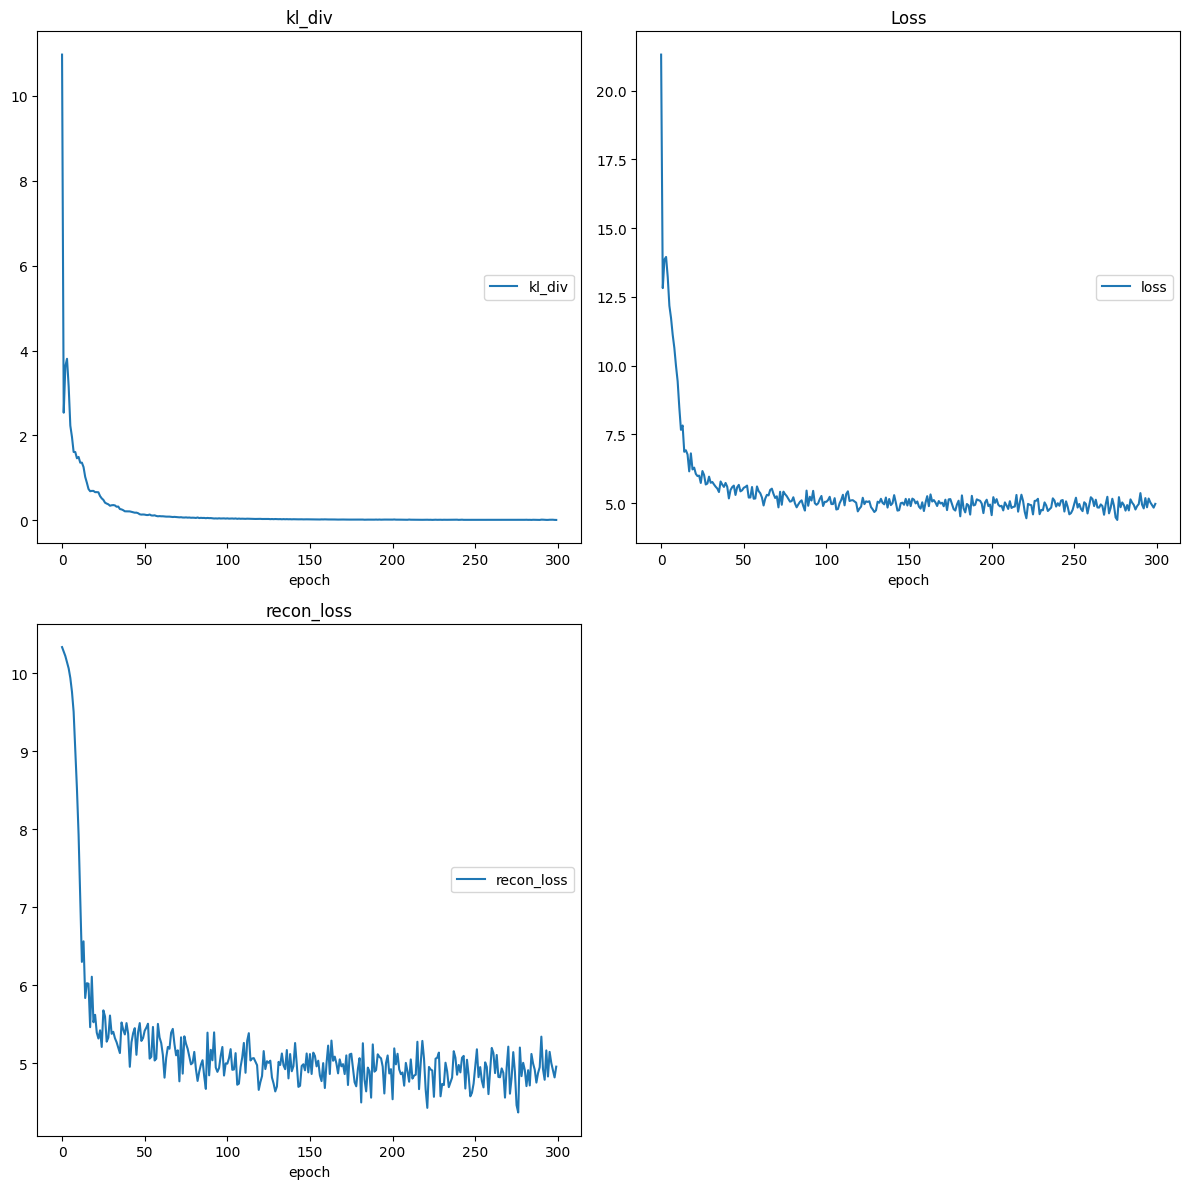

kl_div
	kl_div           	 (min:    0.010, max:   10.971, cur:    0.010)
Loss
	loss             	 (min:    4.383, max:   21.308, cur:    4.968)
recon_loss
	recon_loss       	 (min:    4.371, max:   10.337, cur:    4.958)


In [29]:
# At long last, train the model!
train_vae(
    model=textVAE,
    train_loader=dataloader,
    optimizer=optimizer,
)

In [30]:
# Generate a few examples.
num_samples = 5
max_length = 50

tokens = textVAE.generate(
    num_samples = num_samples,
    max_length = max_length
)

text = tokenizer.batch_decode(tokens, skip_special_tokens=True)

for i, t in enumerate(text):
    print(f"Sample {i}: {t}")

Sample 0: ........................
Sample 1: ..........................
Sample 2: .........................
Sample 3: ..........................
Sample 4: ..........................
